In [1]:
import sys, os

sys.path.append("../")
from src.qaoa_scheduling import QAOACircuit, QAOAScheduler, SchedulingResult
import numpy as np
import matplotlib.pyplot as plt
from src.visualization import visualize_cyclic_graph

# Create plots directory
os.makedirs("plots", exist_ok=True)

In [2]:
selected_schedules = ["Layered", "MIP"]
# selected_schedules = ["Greedy", "MIP"]


def run_example_comparison(circuit: QAOACircuit, name: str):
    """Run and compare all scheduling methods."""
    print(f"\n{name} Example:")
    print("=" * 50)

    # Visualize circuit graph
    visualize_cyclic_graph(circuit, save_path=f"plots/{name.lower()}_graph.pdf")

    # Create scheduler
    scheduler = QAOAScheduler(circuit)

    print("\nGate times:")
    for gate, time in circuit.gamma_gates.items():
        print(f"  γ(Q{gate[0]}-Q{gate[1]}): {time:.2f}")

    # Get schedules from all methods
    print("\nSolving with Linear Programming...")
    lp_result = scheduler.solve_lp()

    lp_prog = scheduler.get_lp_model()
    print(lp_prog)

    print("\nSolving with Layered approach...")
    layered_result = scheduler.schedule_layered()

    print("\nSolving with Greedy approach...")
    greedy_result = scheduler.schedule_greedy()  # Add Greedy scheduling calculation

    seqt = lp_result.total_time_before
    layt = layered_result.total_time_after
    lpt = lp_result.total_time_after
    greedyt = greedy_result.total_time_after  # Add Greedy time variable

    print("\nResults Comparison:")
    print("-" * 30)
    print(f"Sequential time:  {seqt:.2f}")
    print(f"Layered time:     {layt:.2f}")
    print(f"Greedy time:      {greedyt:.2f}")  # Add Greedy result to output
    print(f"LP time:          {lpt:.2f}")

    print("\nImprovements:")
    print(f"LP vs Layered:     {(np.abs(lpt - layt))/layt:.1%}")
    print(
        f"LP vs Greedy:      {(np.abs(lpt - greedyt))/greedyt:.1%}"
    )  # Add LP vs Greedy comparison
    print(
        f"Greedy vs Layered: {(np.abs(greedyt - layt))/layt:.1%}"
    )  # Add Greedy vs Layered comparison
    print(f"LP vs Sequential:  {(np.abs(lpt - seqt))/seqt:.1%}")

    # Visualize all schedules
    results = {
        "Sequential": SchedulingResult(
            cost_layers=[],  # Will be handled specially in visualization
            mixer_layer=lp_result.mixer_layer,
            total_time_before=lp_result.total_time_before,
            total_time_after=lp_result.total_time_before,
            improvement=0,
            gate_timings={},
        ),
        "Layered": layered_result,
        "Greedy": greedy_result,  # Add Greedy result to the visualization
        "MIP": lp_result,
    }
    scheduler.visualize_schedule_comparison(
        results, selected_schedules, save_path=f"plots/{name.lower()}_schedule.pdf"
    )

    return layered_result, greedy_result, lp_result  # Also return the greedy result

### C5 Example

In [3]:
### C5 Example
def example_c5_circuit() -> QAOACircuit:
    """Create example QAOA circuit on 5 qubits."""
    n_qubits = 5
    gamma_gates = {
        (0, 1): 5.0,  # γ1
        (1, 2): 4.0,  # γ2
        (2, 3): 3.0,  # γ3
        (3, 4): 2.0,  # γ4
        (4, 0): 1.0,  # γ5
    }
    beta_time = 1.0

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)


C5 Fixed Example:


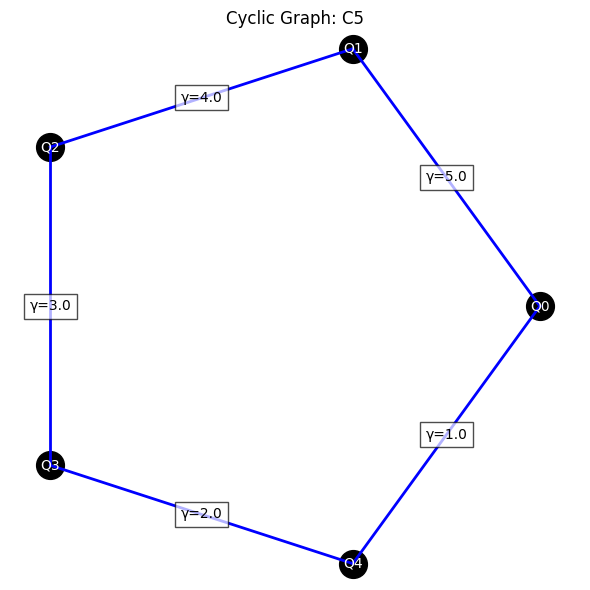


Gate times:
  γ(Q0-Q1): 5.00
  γ(Q1-Q2): 4.00
  γ(Q2-Q3): 3.00
  γ(Q3-Q4): 2.00
  γ(Q4-Q0): 1.00

Solving with Linear Programming...
QAOA Circuit with 5 qubits

Gate times:
t_(0, 1) = 5.0
t_(1, 2) = 4.0
t_(2, 3) = 3.0
t_(3, 4) = 2.0
t_(4, 0) = 1.0
t_β = 1.0

Minimize: Z

Subject to:

1. Non-overlapping gates:
x_(0, 1) ≥ x_(1, 2) + 4.0 - M⋅y_(0, 1)(1, 2)
x_(0, 1) ≥ x_(4, 0) + 1.0 - M⋅y_(0, 1)(4, 0)
x_(1, 2) ≥ x_(2, 3) + 3.0 - M⋅y_(1, 2)(2, 3)
x_(2, 3) ≥ x_(3, 4) + 2.0 - M⋅y_(2, 3)(3, 4)
x_(3, 4) ≥ x_(4, 0) + 1.0 - M⋅y_(3, 4)(4, 0)
x_(1, 2) ≥ x_(0, 1) + 5.0 - M⋅(1-y_(0, 1)(1, 2))
x_(4, 0) ≥ x_(0, 1) + 5.0 - M⋅(1-y_(0, 1)(4, 0))
x_(2, 3) ≥ x_(1, 2) + 4.0 - M⋅(1-y_(1, 2)(2, 3))
x_(3, 4) ≥ x_(2, 3) + 3.0 - M⋅(1-y_(2, 3)(3, 4))
x_(4, 0) ≥ x_(3, 4) + 2.0 - M⋅(1-y_(3, 4)(4, 0))

2. Total time:
Z ≥ x_(0, 1) + 5.0 + 1.0
Z ≥ x_(1, 2) + 4.0 + 1.0
Z ≥ x_(2, 3) + 3.0 + 1.0
Z ≥ x_(3, 4) + 2.0 + 1.0
Z ≥ x_(4, 0) + 1.0 + 1.0

3. Variable domains:
x_g ≥ 0 for all gates g
y_gg' ∈ {0,1} for all conflicti

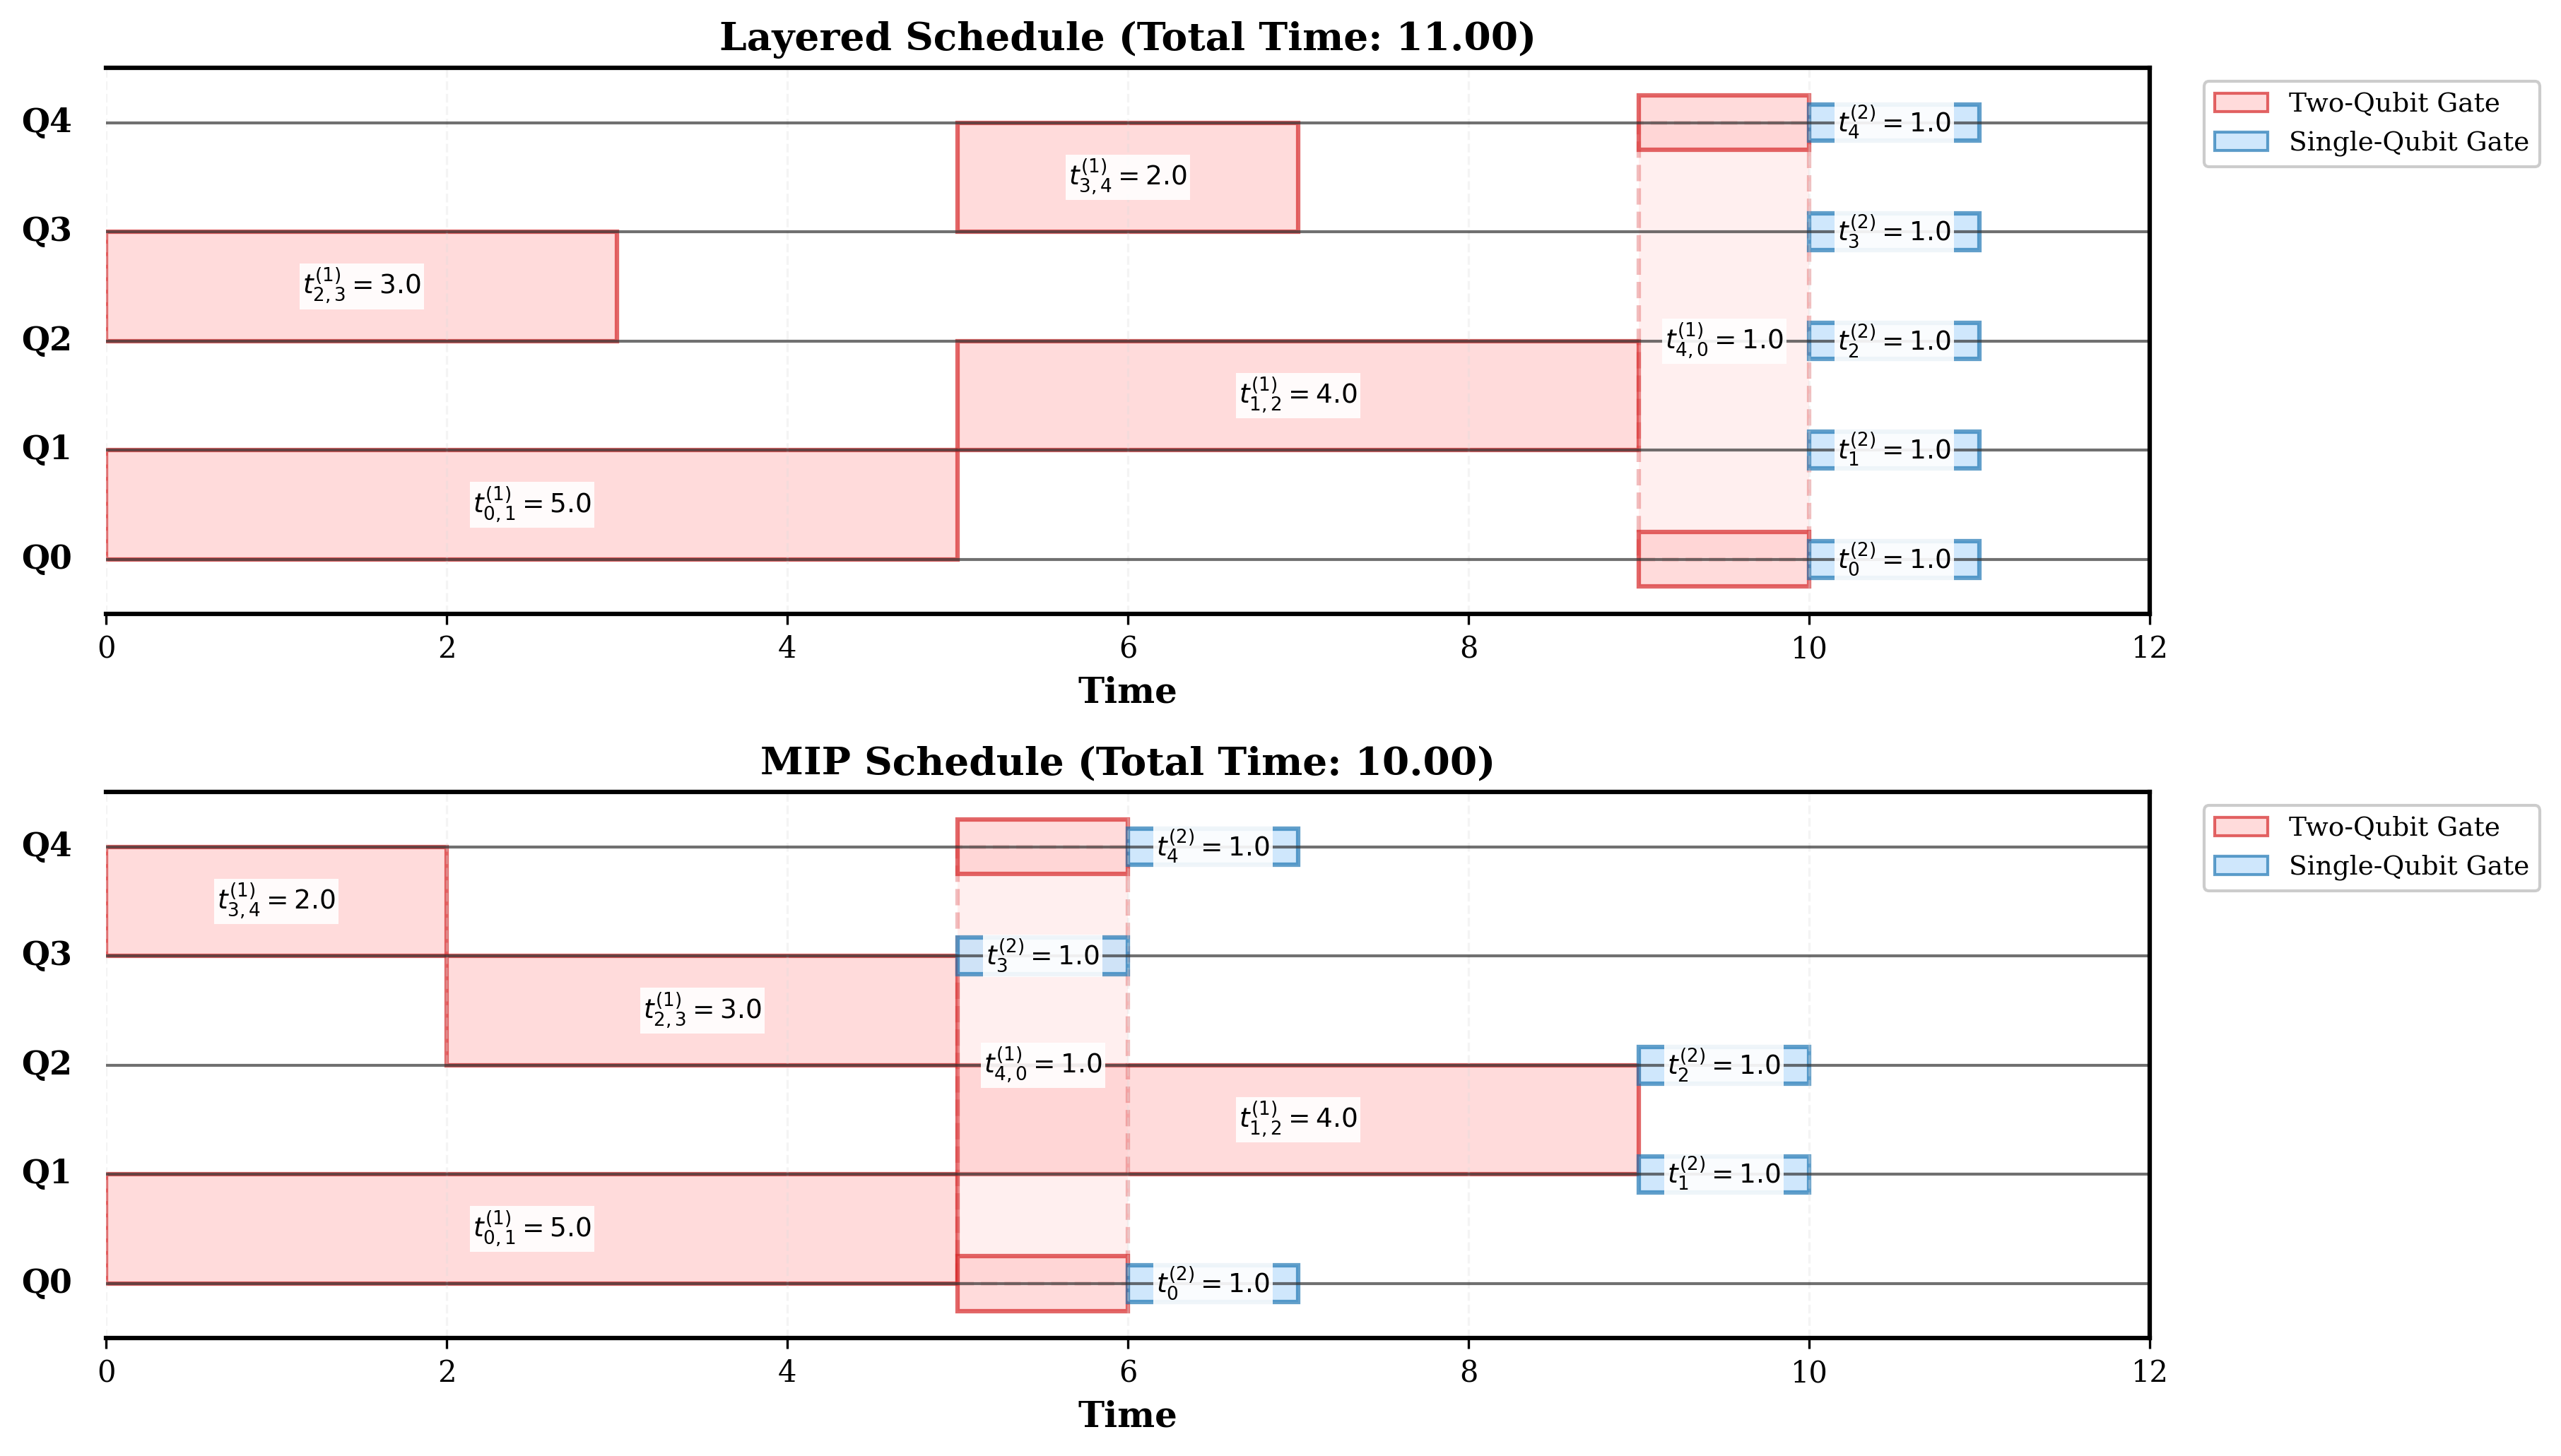

In [4]:
# Run C5 example
c5_circuit = example_c5_circuit()
c5_layered, c5_greedy, c5_lp = run_example_comparison(c5_circuit, "C5 Fixed")

### C7 Example

In [5]:
### C7 Example
def example_c7_circuit() -> QAOACircuit:
    """Create example QAOA circuit on 7 qubits."""
    n_qubits = 7
    gamma_gates = {
        (0, 1): 7.0,  # γ1
        (1, 2): 6.0,  # γ2
        (2, 3): 5.0,  # γ3
        (3, 4): 4.0,  # γ4
        (4, 5): 3.0,  # γ5
        (5, 6): 2.0,  # γ6
        (6, 0): 1.0,  # γ7
    }
    beta_time = 1.0

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)


C7 Fixed Example:


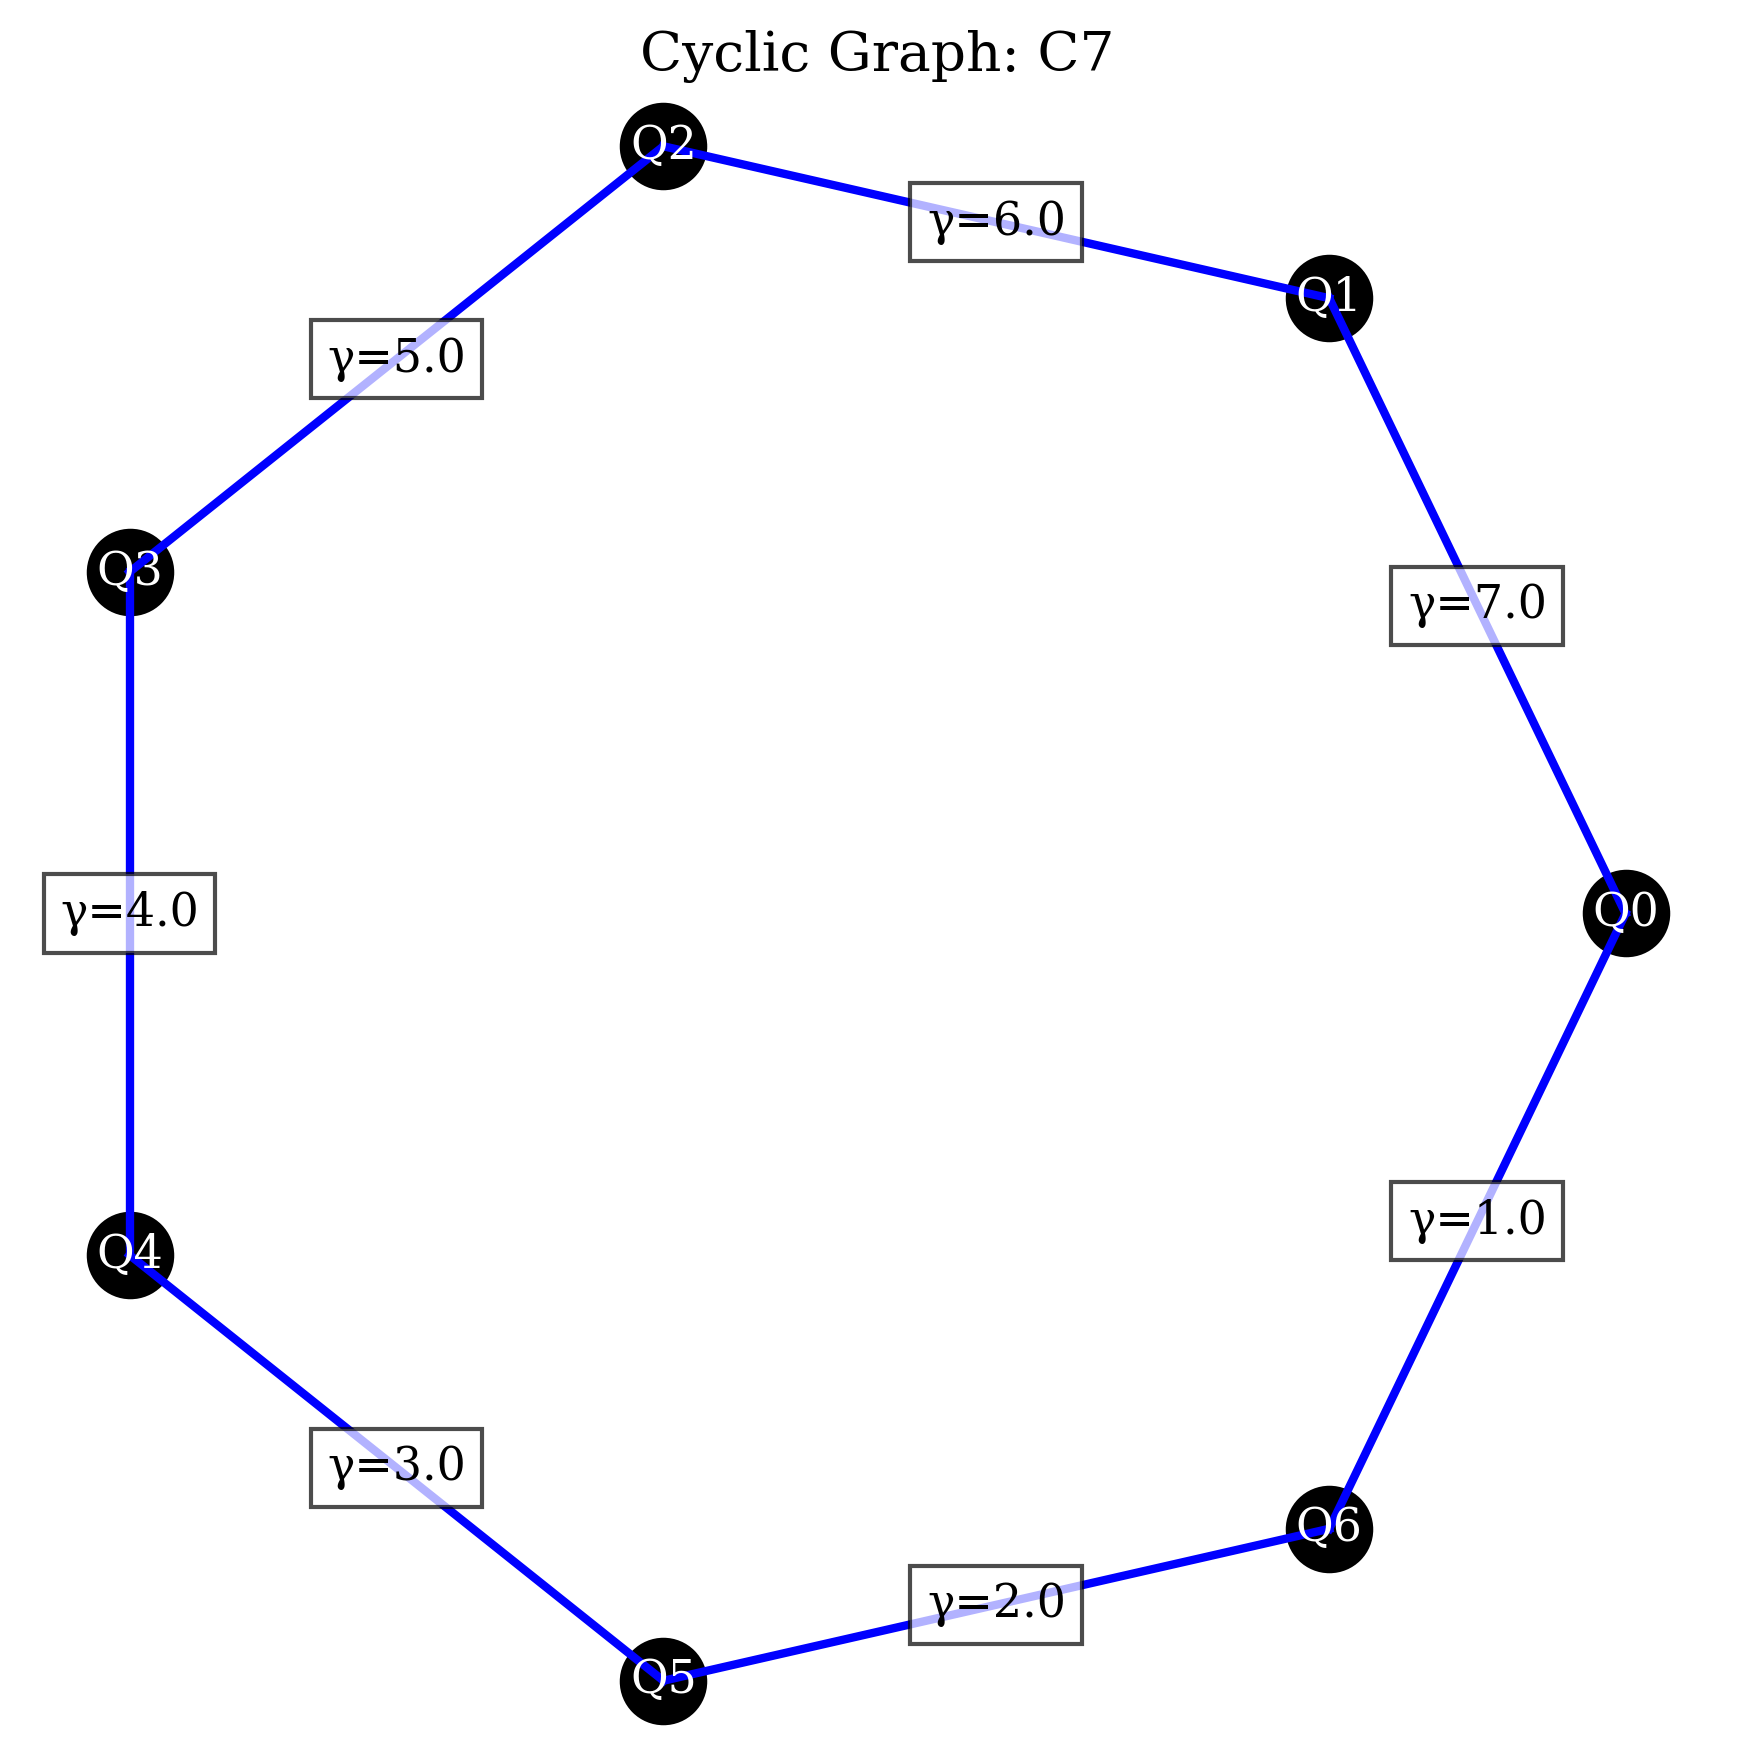


Gate times:
  γ(Q0-Q1): 7.00
  γ(Q1-Q2): 6.00
  γ(Q2-Q3): 5.00
  γ(Q3-Q4): 4.00
  γ(Q4-Q5): 3.00
  γ(Q5-Q6): 2.00
  γ(Q6-Q0): 1.00

Solving with Linear Programming...
QAOA Circuit with 7 qubits

Gate times:
t_(0, 1) = 7.0
t_(1, 2) = 6.0
t_(2, 3) = 5.0
t_(3, 4) = 4.0
t_(4, 5) = 3.0
t_(5, 6) = 2.0
t_(6, 0) = 1.0
t_β = 1.0

Minimize: Z

Subject to:

1. Non-overlapping gates:
x_(0, 1) ≥ x_(1, 2) + 6.0 - M⋅y_(0, 1)(1, 2)
x_(0, 1) ≥ x_(6, 0) + 1.0 - M⋅y_(0, 1)(6, 0)
x_(1, 2) ≥ x_(2, 3) + 5.0 - M⋅y_(1, 2)(2, 3)
x_(2, 3) ≥ x_(3, 4) + 4.0 - M⋅y_(2, 3)(3, 4)
x_(3, 4) ≥ x_(4, 5) + 3.0 - M⋅y_(3, 4)(4, 5)
x_(4, 5) ≥ x_(5, 6) + 2.0 - M⋅y_(4, 5)(5, 6)
x_(5, 6) ≥ x_(6, 0) + 1.0 - M⋅y_(5, 6)(6, 0)
x_(1, 2) ≥ x_(0, 1) + 7.0 - M⋅(1-y_(0, 1)(1, 2))
x_(6, 0) ≥ x_(0, 1) + 7.0 - M⋅(1-y_(0, 1)(6, 0))
x_(2, 3) ≥ x_(1, 2) + 6.0 - M⋅(1-y_(1, 2)(2, 3))
x_(3, 4) ≥ x_(2, 3) + 5.0 - M⋅(1-y_(2, 3)(3, 4))
x_(4, 5) ≥ x_(3, 4) + 4.0 - M⋅(1-y_(3, 4)(4, 5))
x_(5, 6) ≥ x_(4, 5) + 3.0 - M⋅(1-y_(4, 5)(5, 6))
x_(6, 0) ≥ x_(5

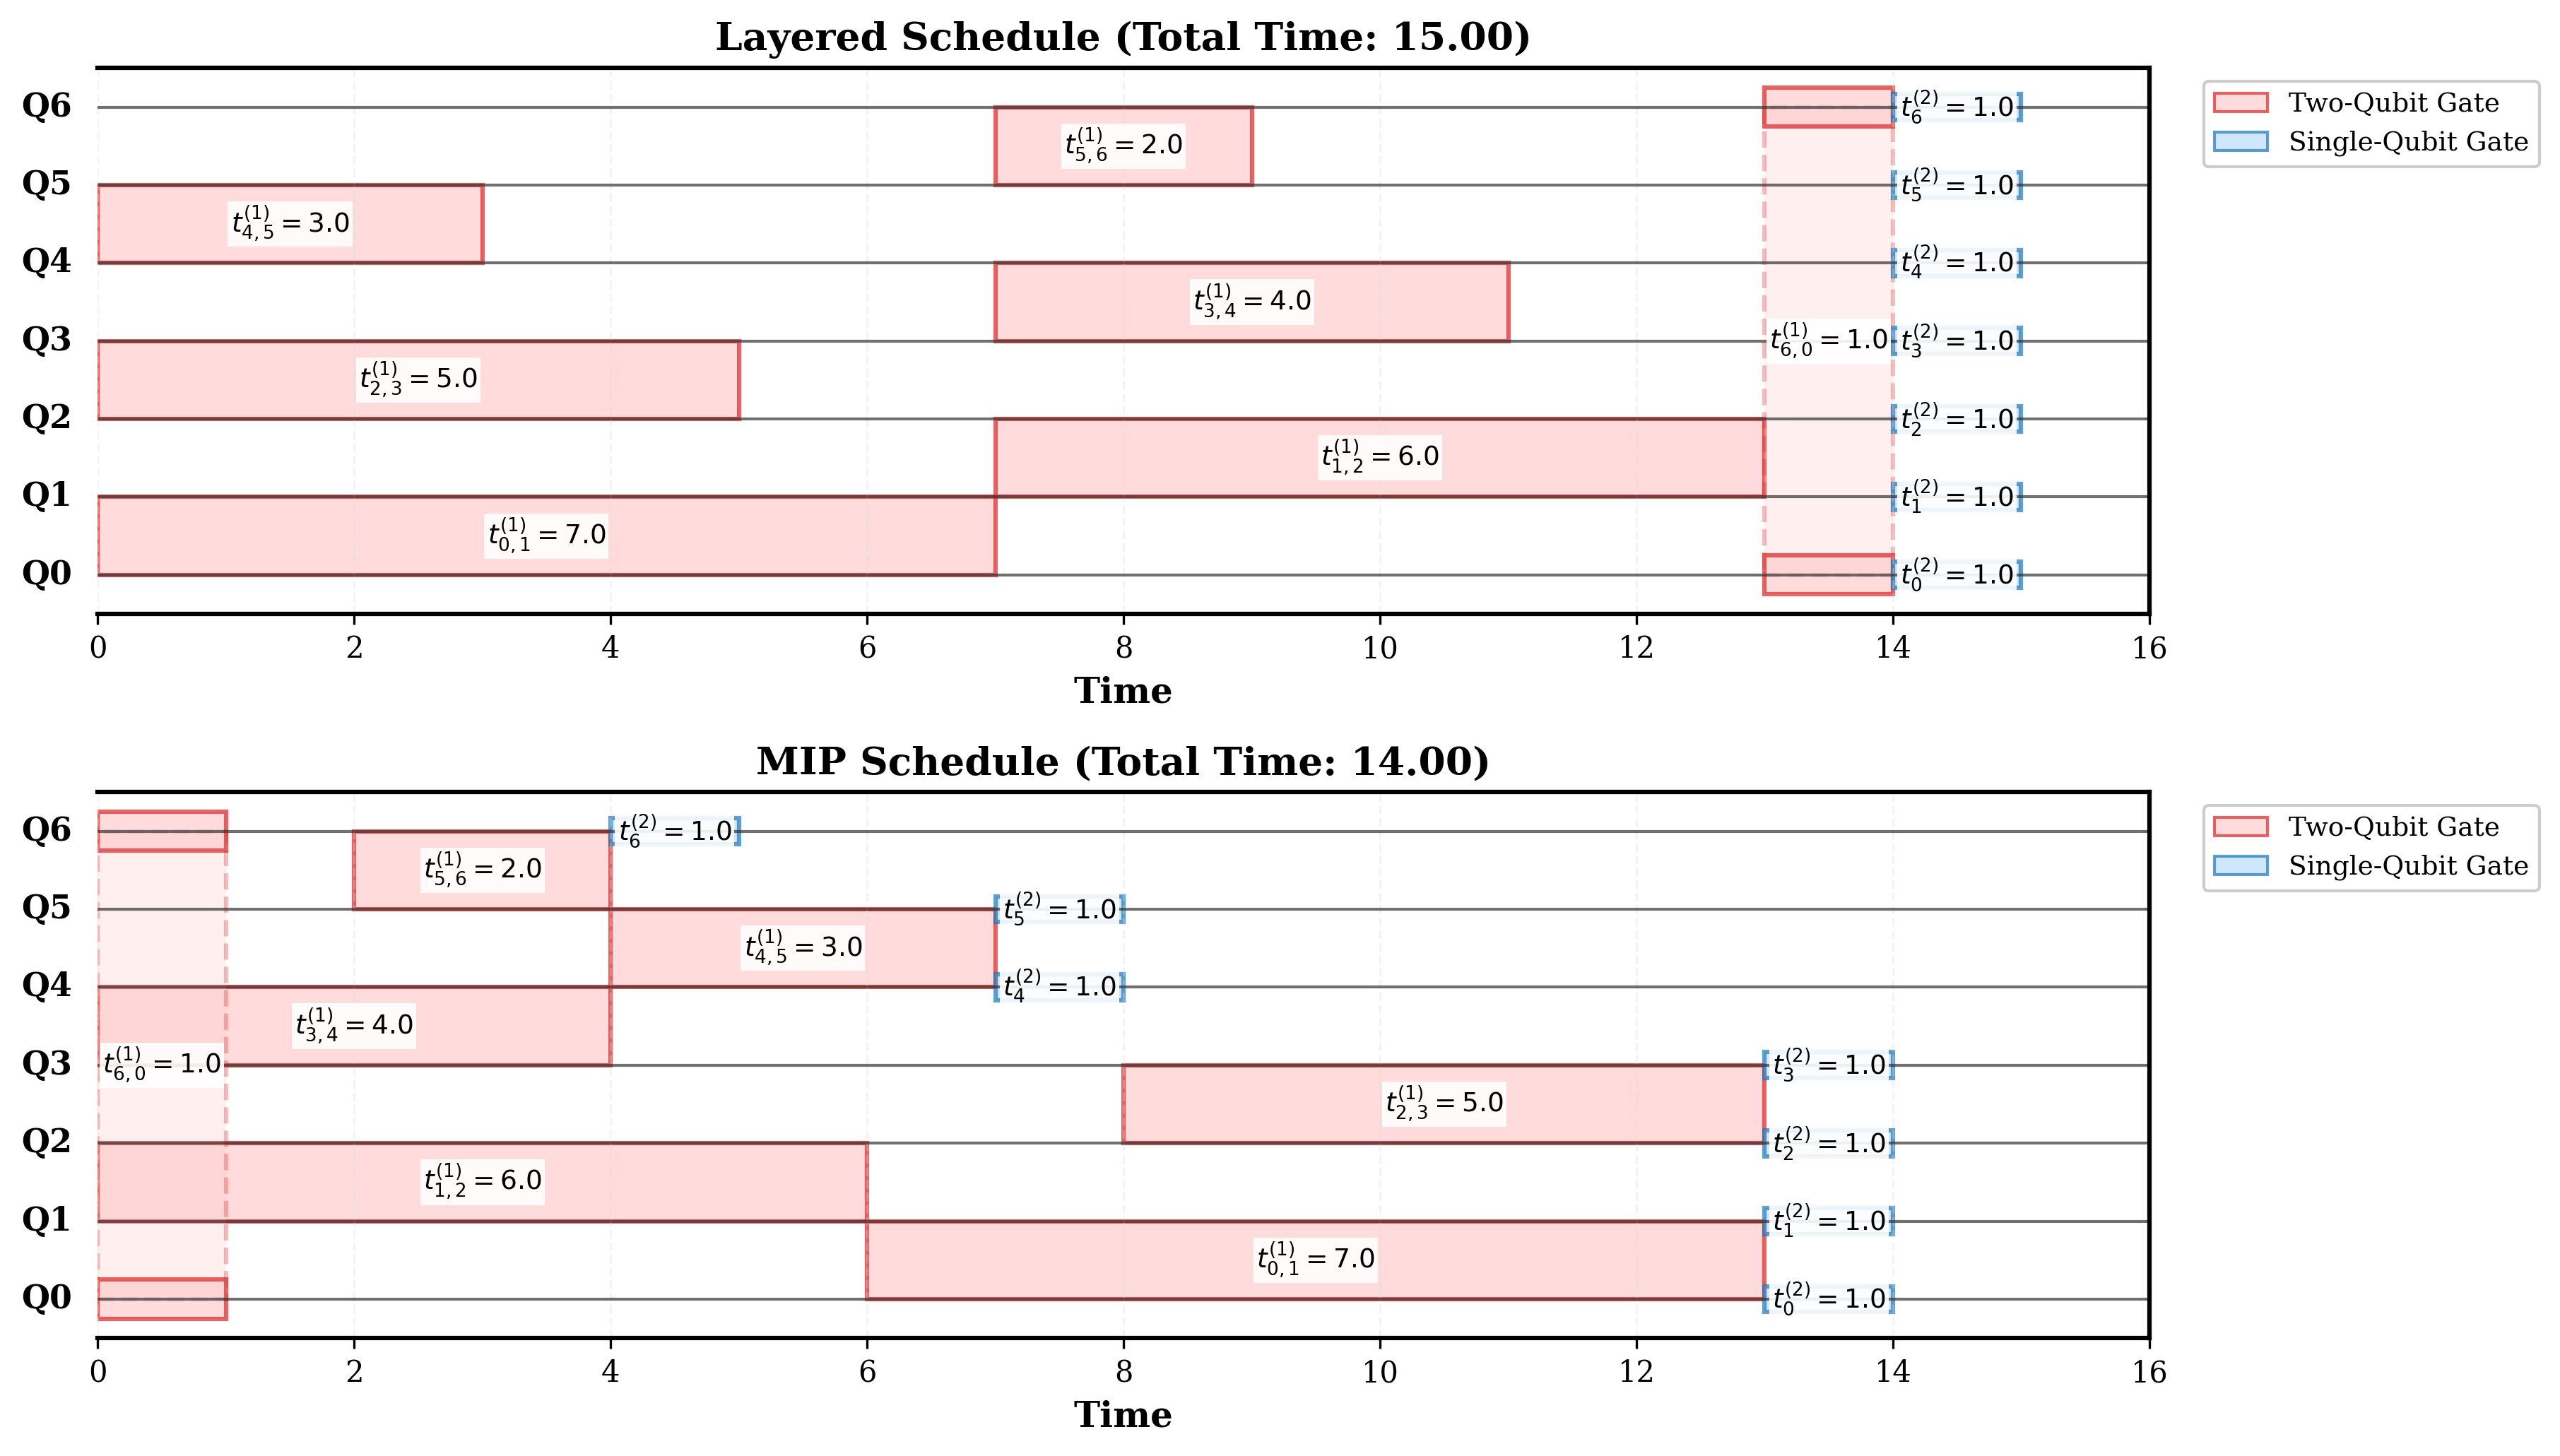

In [6]:
# Run C7 example
c7_circuit = example_c7_circuit()
c7_layered, c7_greedy, c7_lp = run_example_comparison(c7_circuit, "C7 Fixed")

### K5 Example (Complete Graph)

In [7]:
### K5 Example (Complete Graph)
def example_k5_circuit() -> QAOACircuit:
    """Create example QAOA circuit on 5 qubits with complete graph connectivity."""
    n_qubits = 5
    gamma_gates = {
        # Connections from vertex 0
        (0, 1): 10.0,
        (0, 2): 9.0,
        (0, 3): 8.0,
        (0, 4): 7.0,
        # Connections from vertex 1
        (1, 2): 6.0,
        (1, 3): 5.0,
        (1, 4): 4.0,
        # Connections from vertex 2
        (2, 3): 3.0,
        (2, 4): 2.0,
        # Connection from vertex 3
        (3, 4): 1.0,
    }
    beta_time = 1.0

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)


K5 Example:


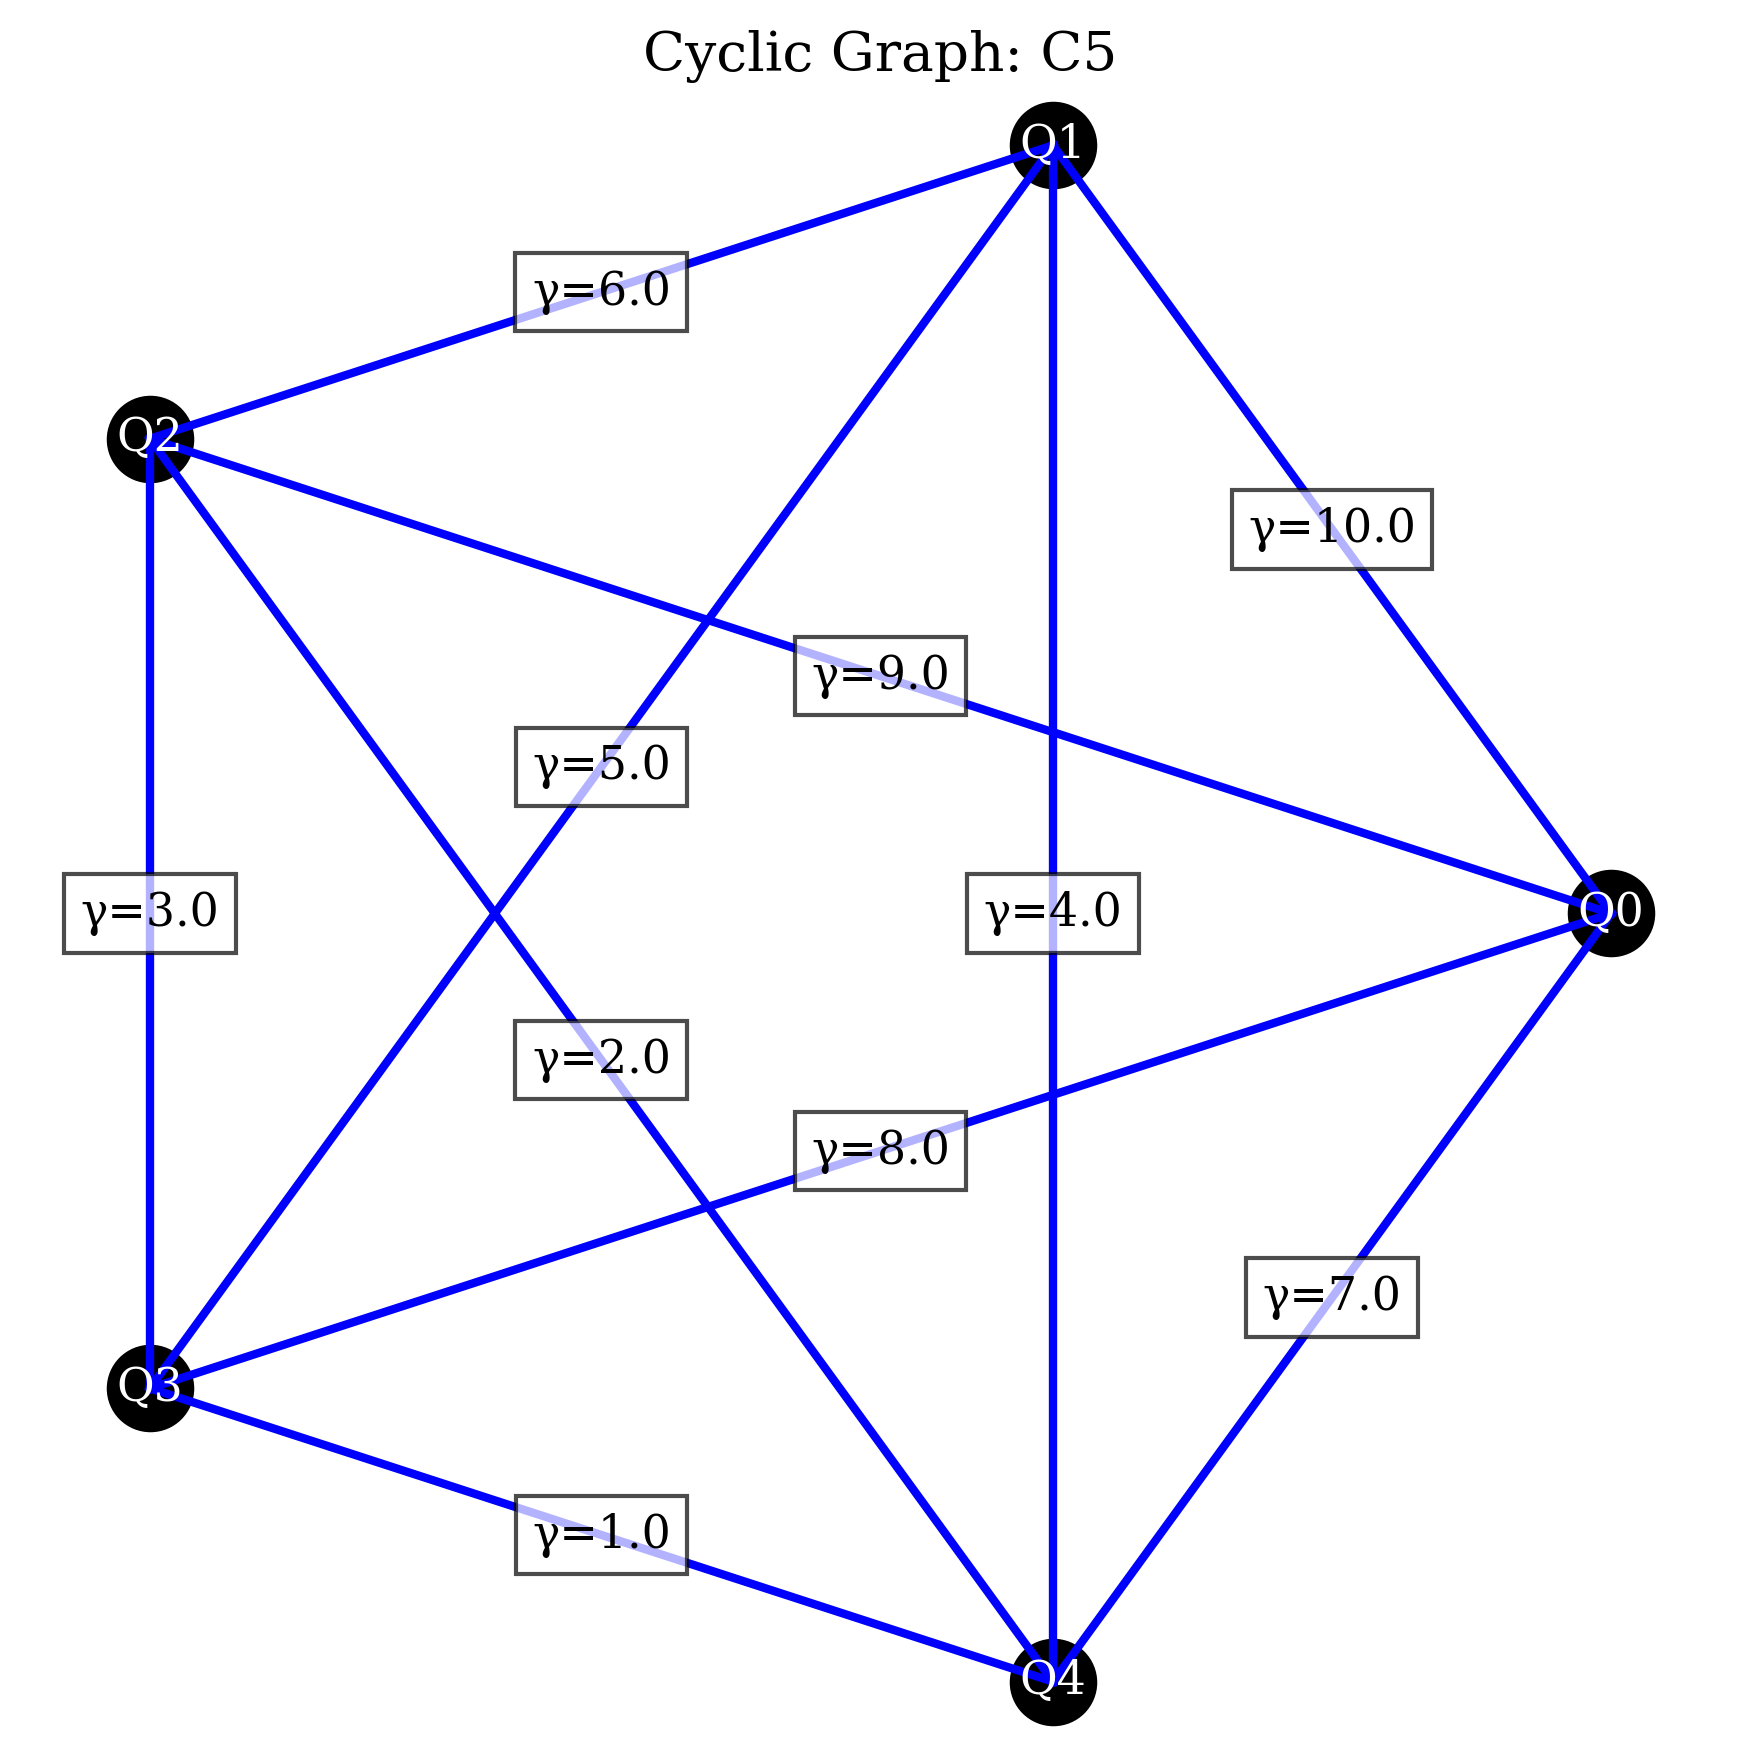


Gate times:
  γ(Q0-Q1): 10.00
  γ(Q0-Q2): 9.00
  γ(Q0-Q3): 8.00
  γ(Q0-Q4): 7.00
  γ(Q1-Q2): 6.00
  γ(Q1-Q3): 5.00
  γ(Q1-Q4): 4.00
  γ(Q2-Q3): 3.00
  γ(Q2-Q4): 2.00
  γ(Q3-Q4): 1.00

Solving with Linear Programming...
QAOA Circuit with 5 qubits

Gate times:
t_(0, 1) = 10.0
t_(0, 2) = 9.0
t_(0, 3) = 8.0
t_(0, 4) = 7.0
t_(1, 2) = 6.0
t_(1, 3) = 5.0
t_(1, 4) = 4.0
t_(2, 3) = 3.0
t_(2, 4) = 2.0
t_(3, 4) = 1.0
t_β = 1.0

Minimize: Z

Subject to:

1. Non-overlapping gates:
x_(0, 1) ≥ x_(0, 2) + 9.0 - M⋅y_(0, 1)(0, 2)
x_(0, 1) ≥ x_(0, 3) + 8.0 - M⋅y_(0, 1)(0, 3)
x_(0, 1) ≥ x_(0, 4) + 7.0 - M⋅y_(0, 1)(0, 4)
x_(0, 1) ≥ x_(1, 2) + 6.0 - M⋅y_(0, 1)(1, 2)
x_(0, 1) ≥ x_(1, 3) + 5.0 - M⋅y_(0, 1)(1, 3)
x_(0, 1) ≥ x_(1, 4) + 4.0 - M⋅y_(0, 1)(1, 4)
x_(0, 2) ≥ x_(0, 3) + 8.0 - M⋅y_(0, 2)(0, 3)
x_(0, 2) ≥ x_(0, 4) + 7.0 - M⋅y_(0, 2)(0, 4)
x_(0, 2) ≥ x_(1, 2) + 6.0 - M⋅y_(0, 2)(1, 2)
x_(0, 2) ≥ x_(2, 3) + 3.0 - M⋅y_(0, 2)(2, 3)
x_(0, 2) ≥ x_(2, 4) + 2.0 - M⋅y_(0, 2)(2, 4)
x_(0, 3) ≥ x_(0, 4) + 7.0 - M⋅y

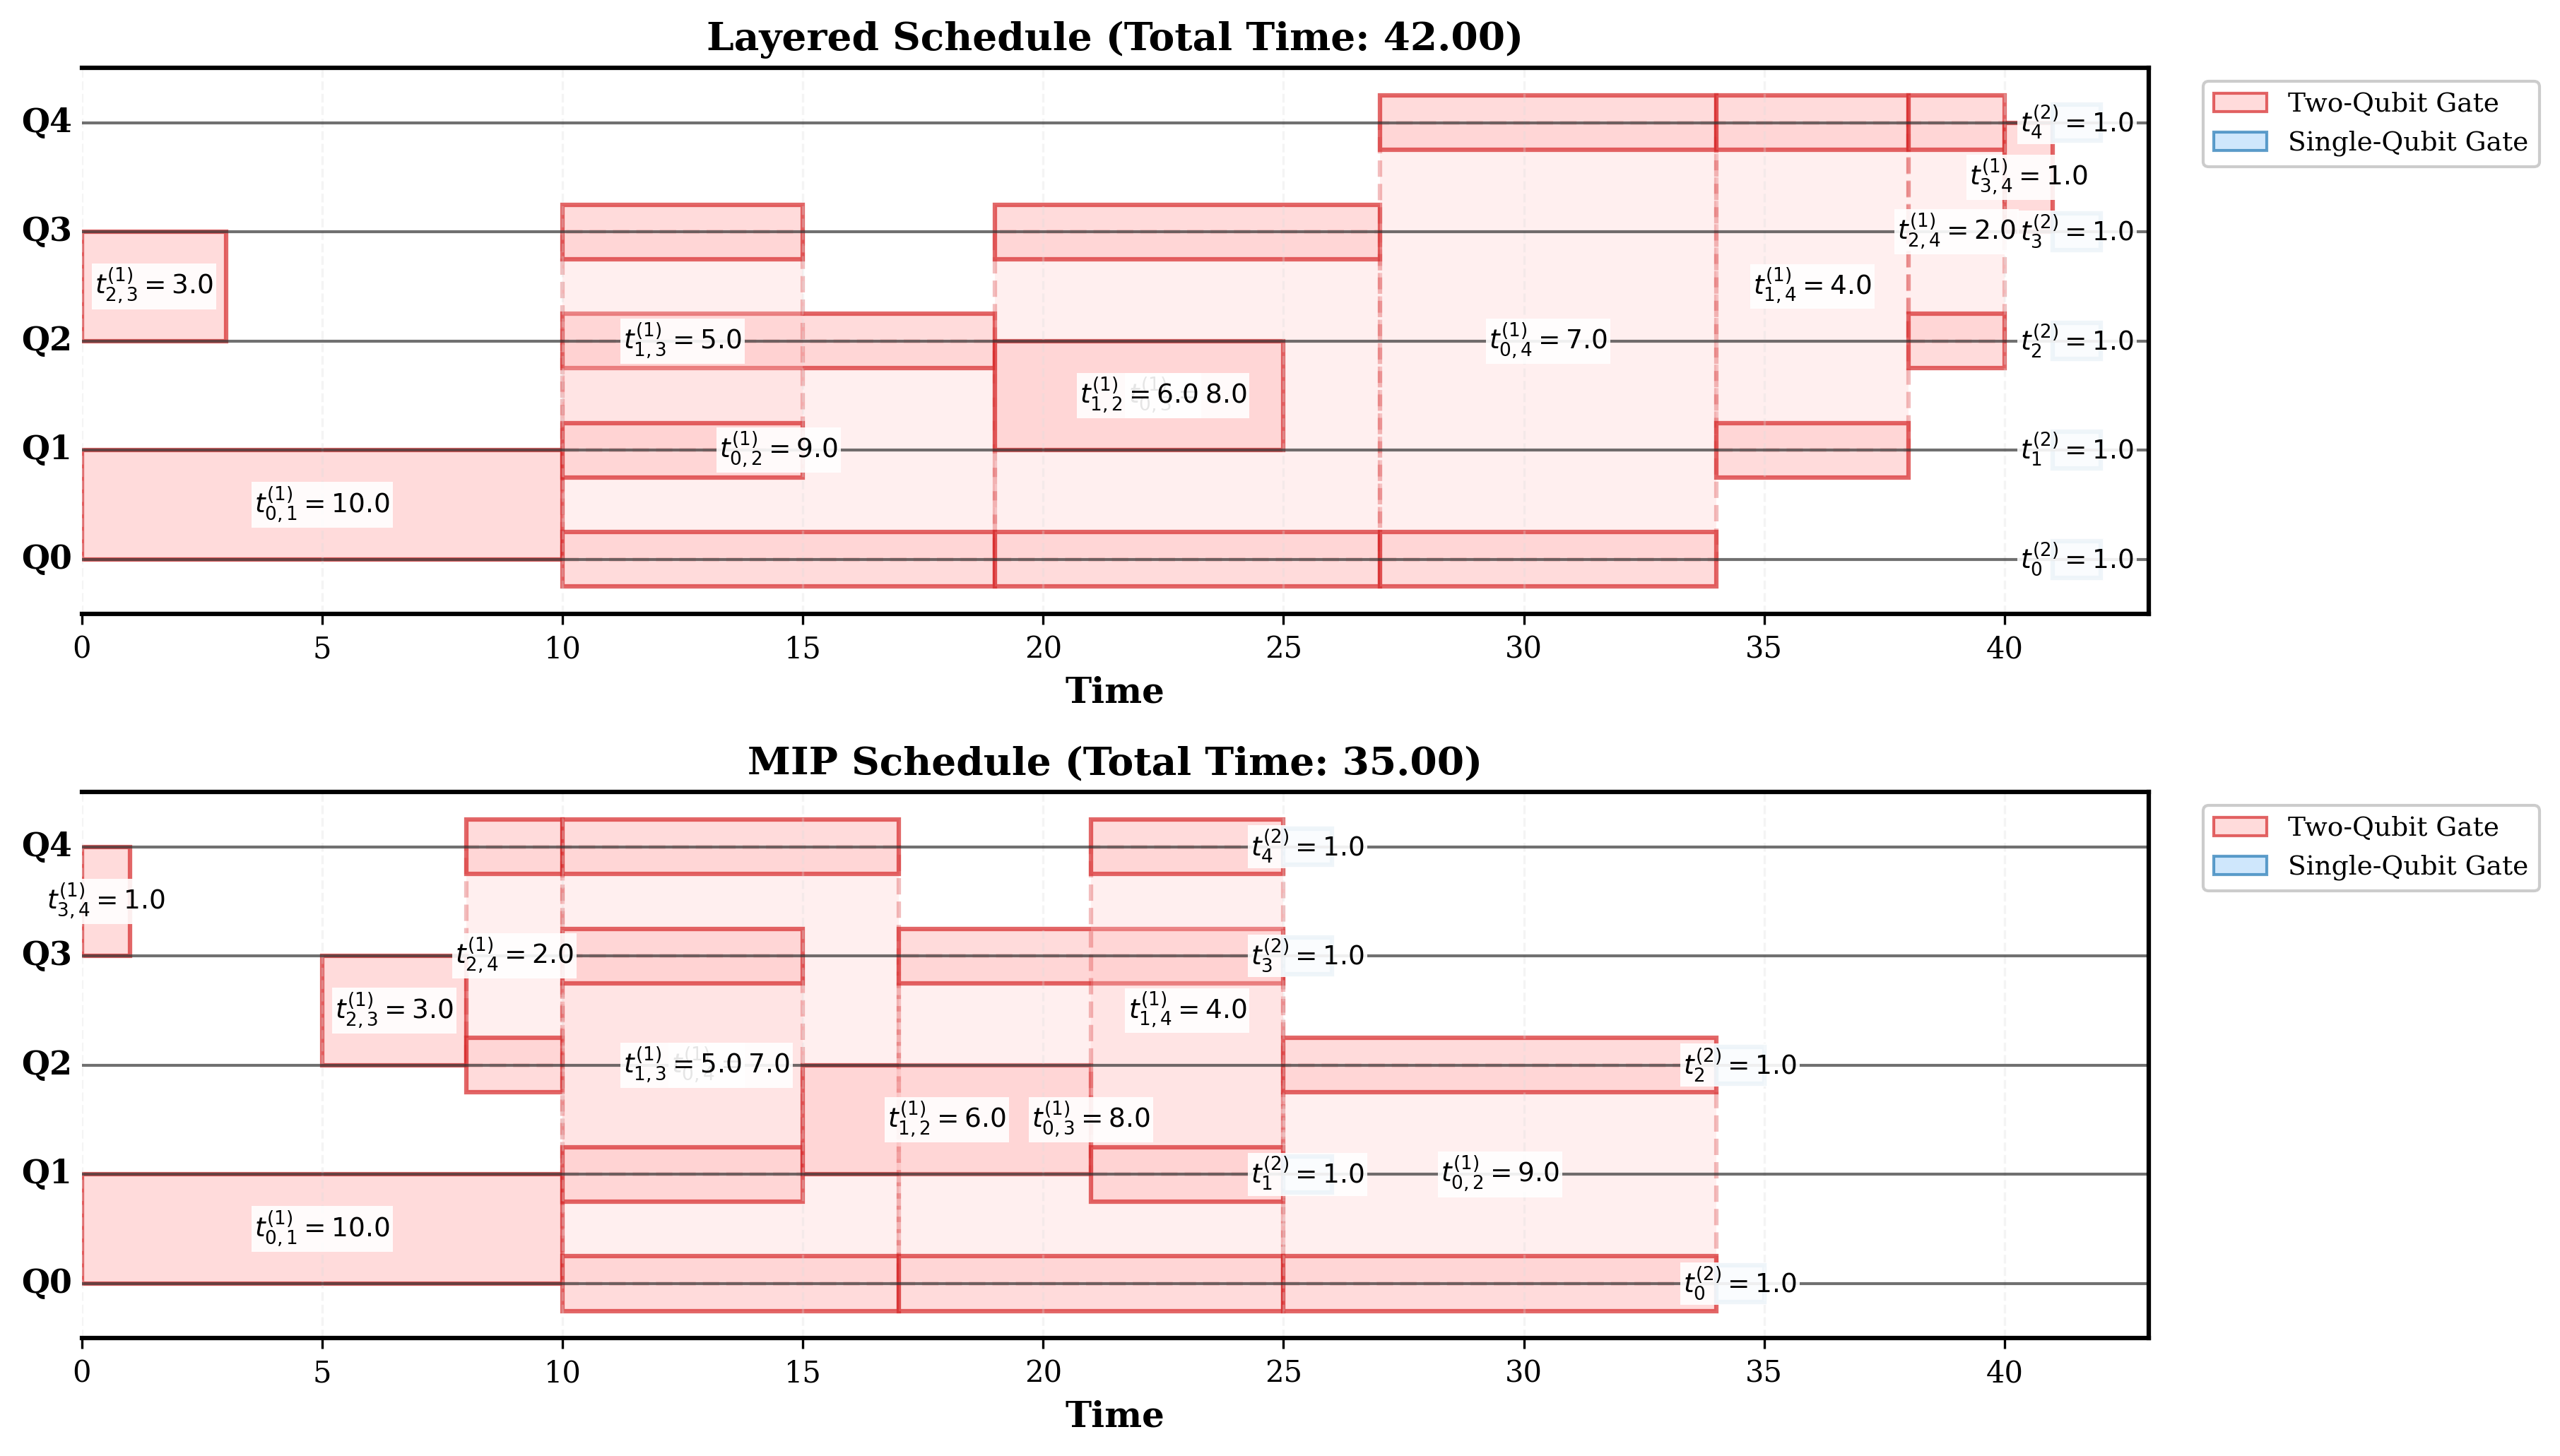

In [8]:
# Run K5 example
k5_circuit = example_k5_circuit()
k5_layered, k5_greedy, k5_lp = run_example_comparison(k5_circuit, "K5")


K4 Example:


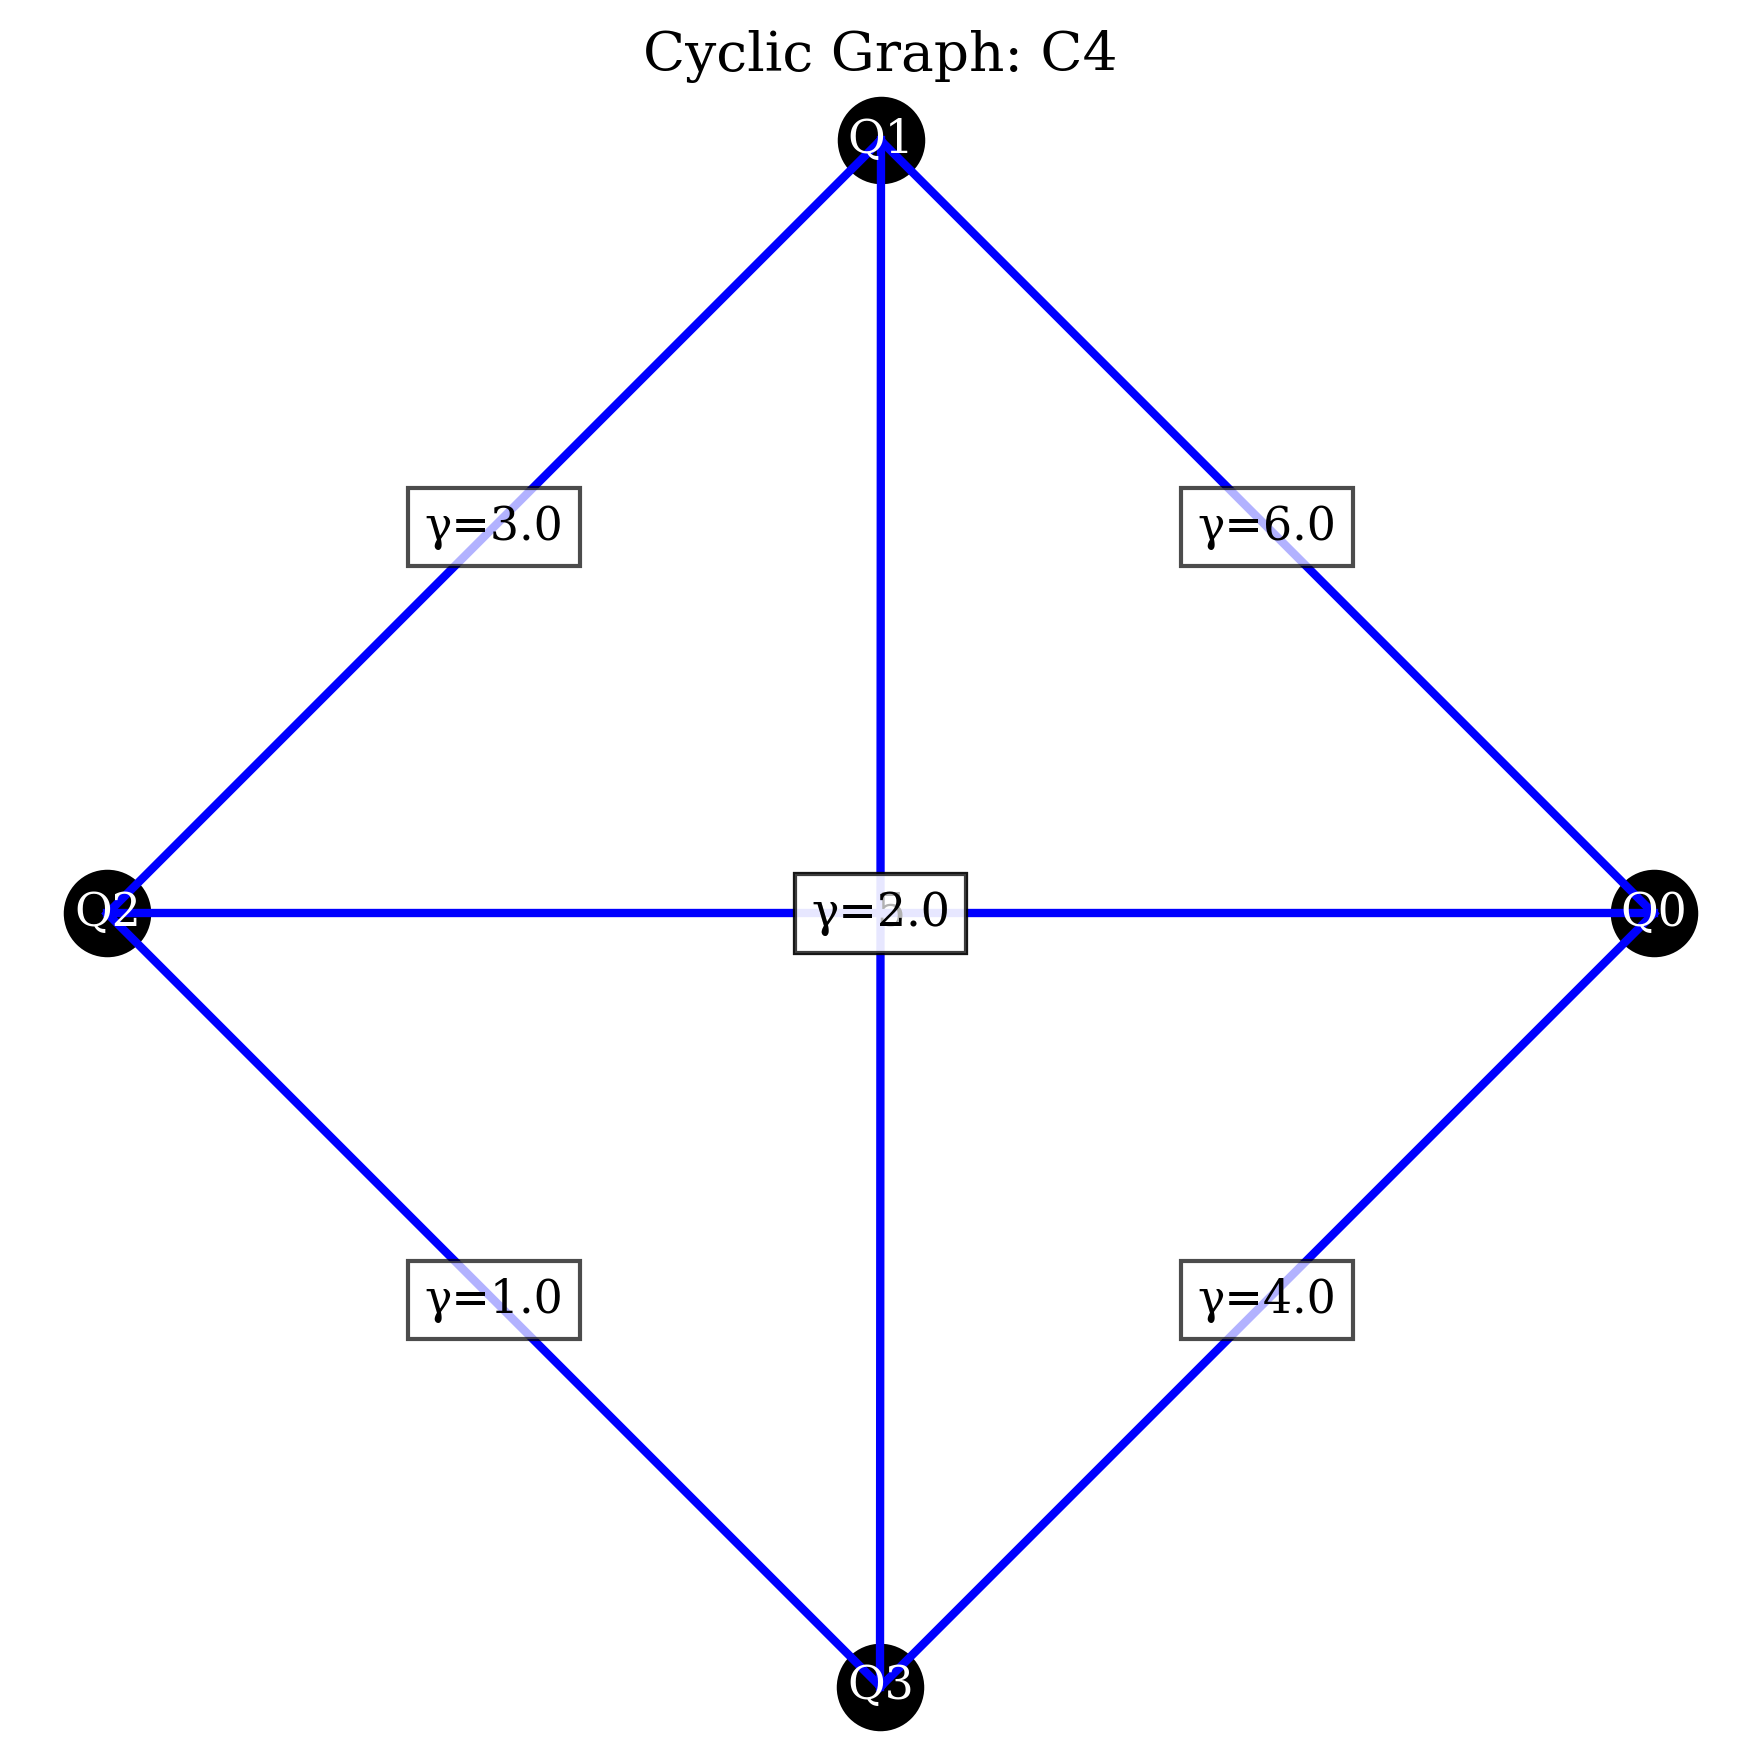


Gate times:
  γ(Q0-Q1): 6.00
  γ(Q0-Q2): 5.00
  γ(Q0-Q3): 4.00
  γ(Q1-Q2): 3.00
  γ(Q1-Q3): 2.00
  γ(Q2-Q3): 1.00

Solving with Linear Programming...
QAOA Circuit with 4 qubits

Gate times:
t_(0, 1) = 6.0
t_(0, 2) = 5.0
t_(0, 3) = 4.0
t_(1, 2) = 3.0
t_(1, 3) = 2.0
t_(2, 3) = 1.0
t_β = 1.0

Minimize: Z

Subject to:

1. Non-overlapping gates:
x_(0, 1) ≥ x_(0, 2) + 5.0 - M⋅y_(0, 1)(0, 2)
x_(0, 1) ≥ x_(0, 3) + 4.0 - M⋅y_(0, 1)(0, 3)
x_(0, 1) ≥ x_(1, 2) + 3.0 - M⋅y_(0, 1)(1, 2)
x_(0, 1) ≥ x_(1, 3) + 2.0 - M⋅y_(0, 1)(1, 3)
x_(0, 2) ≥ x_(0, 3) + 4.0 - M⋅y_(0, 2)(0, 3)
x_(0, 2) ≥ x_(1, 2) + 3.0 - M⋅y_(0, 2)(1, 2)
x_(0, 2) ≥ x_(2, 3) + 1.0 - M⋅y_(0, 2)(2, 3)
x_(0, 3) ≥ x_(1, 3) + 2.0 - M⋅y_(0, 3)(1, 3)
x_(0, 3) ≥ x_(2, 3) + 1.0 - M⋅y_(0, 3)(2, 3)
x_(1, 2) ≥ x_(1, 3) + 2.0 - M⋅y_(1, 2)(1, 3)
x_(1, 2) ≥ x_(2, 3) + 1.0 - M⋅y_(1, 2)(2, 3)
x_(1, 3) ≥ x_(2, 3) + 1.0 - M⋅y_(1, 3)(2, 3)
x_(0, 2) ≥ x_(0, 1) + 6.0 - M⋅(1-y_(0, 1)(0, 2))
x_(0, 3) ≥ x_(0, 1) + 6.0 - M⋅(1-y_(0, 1)(0, 3))
x_(1, 2) ≥ x_(0, 1

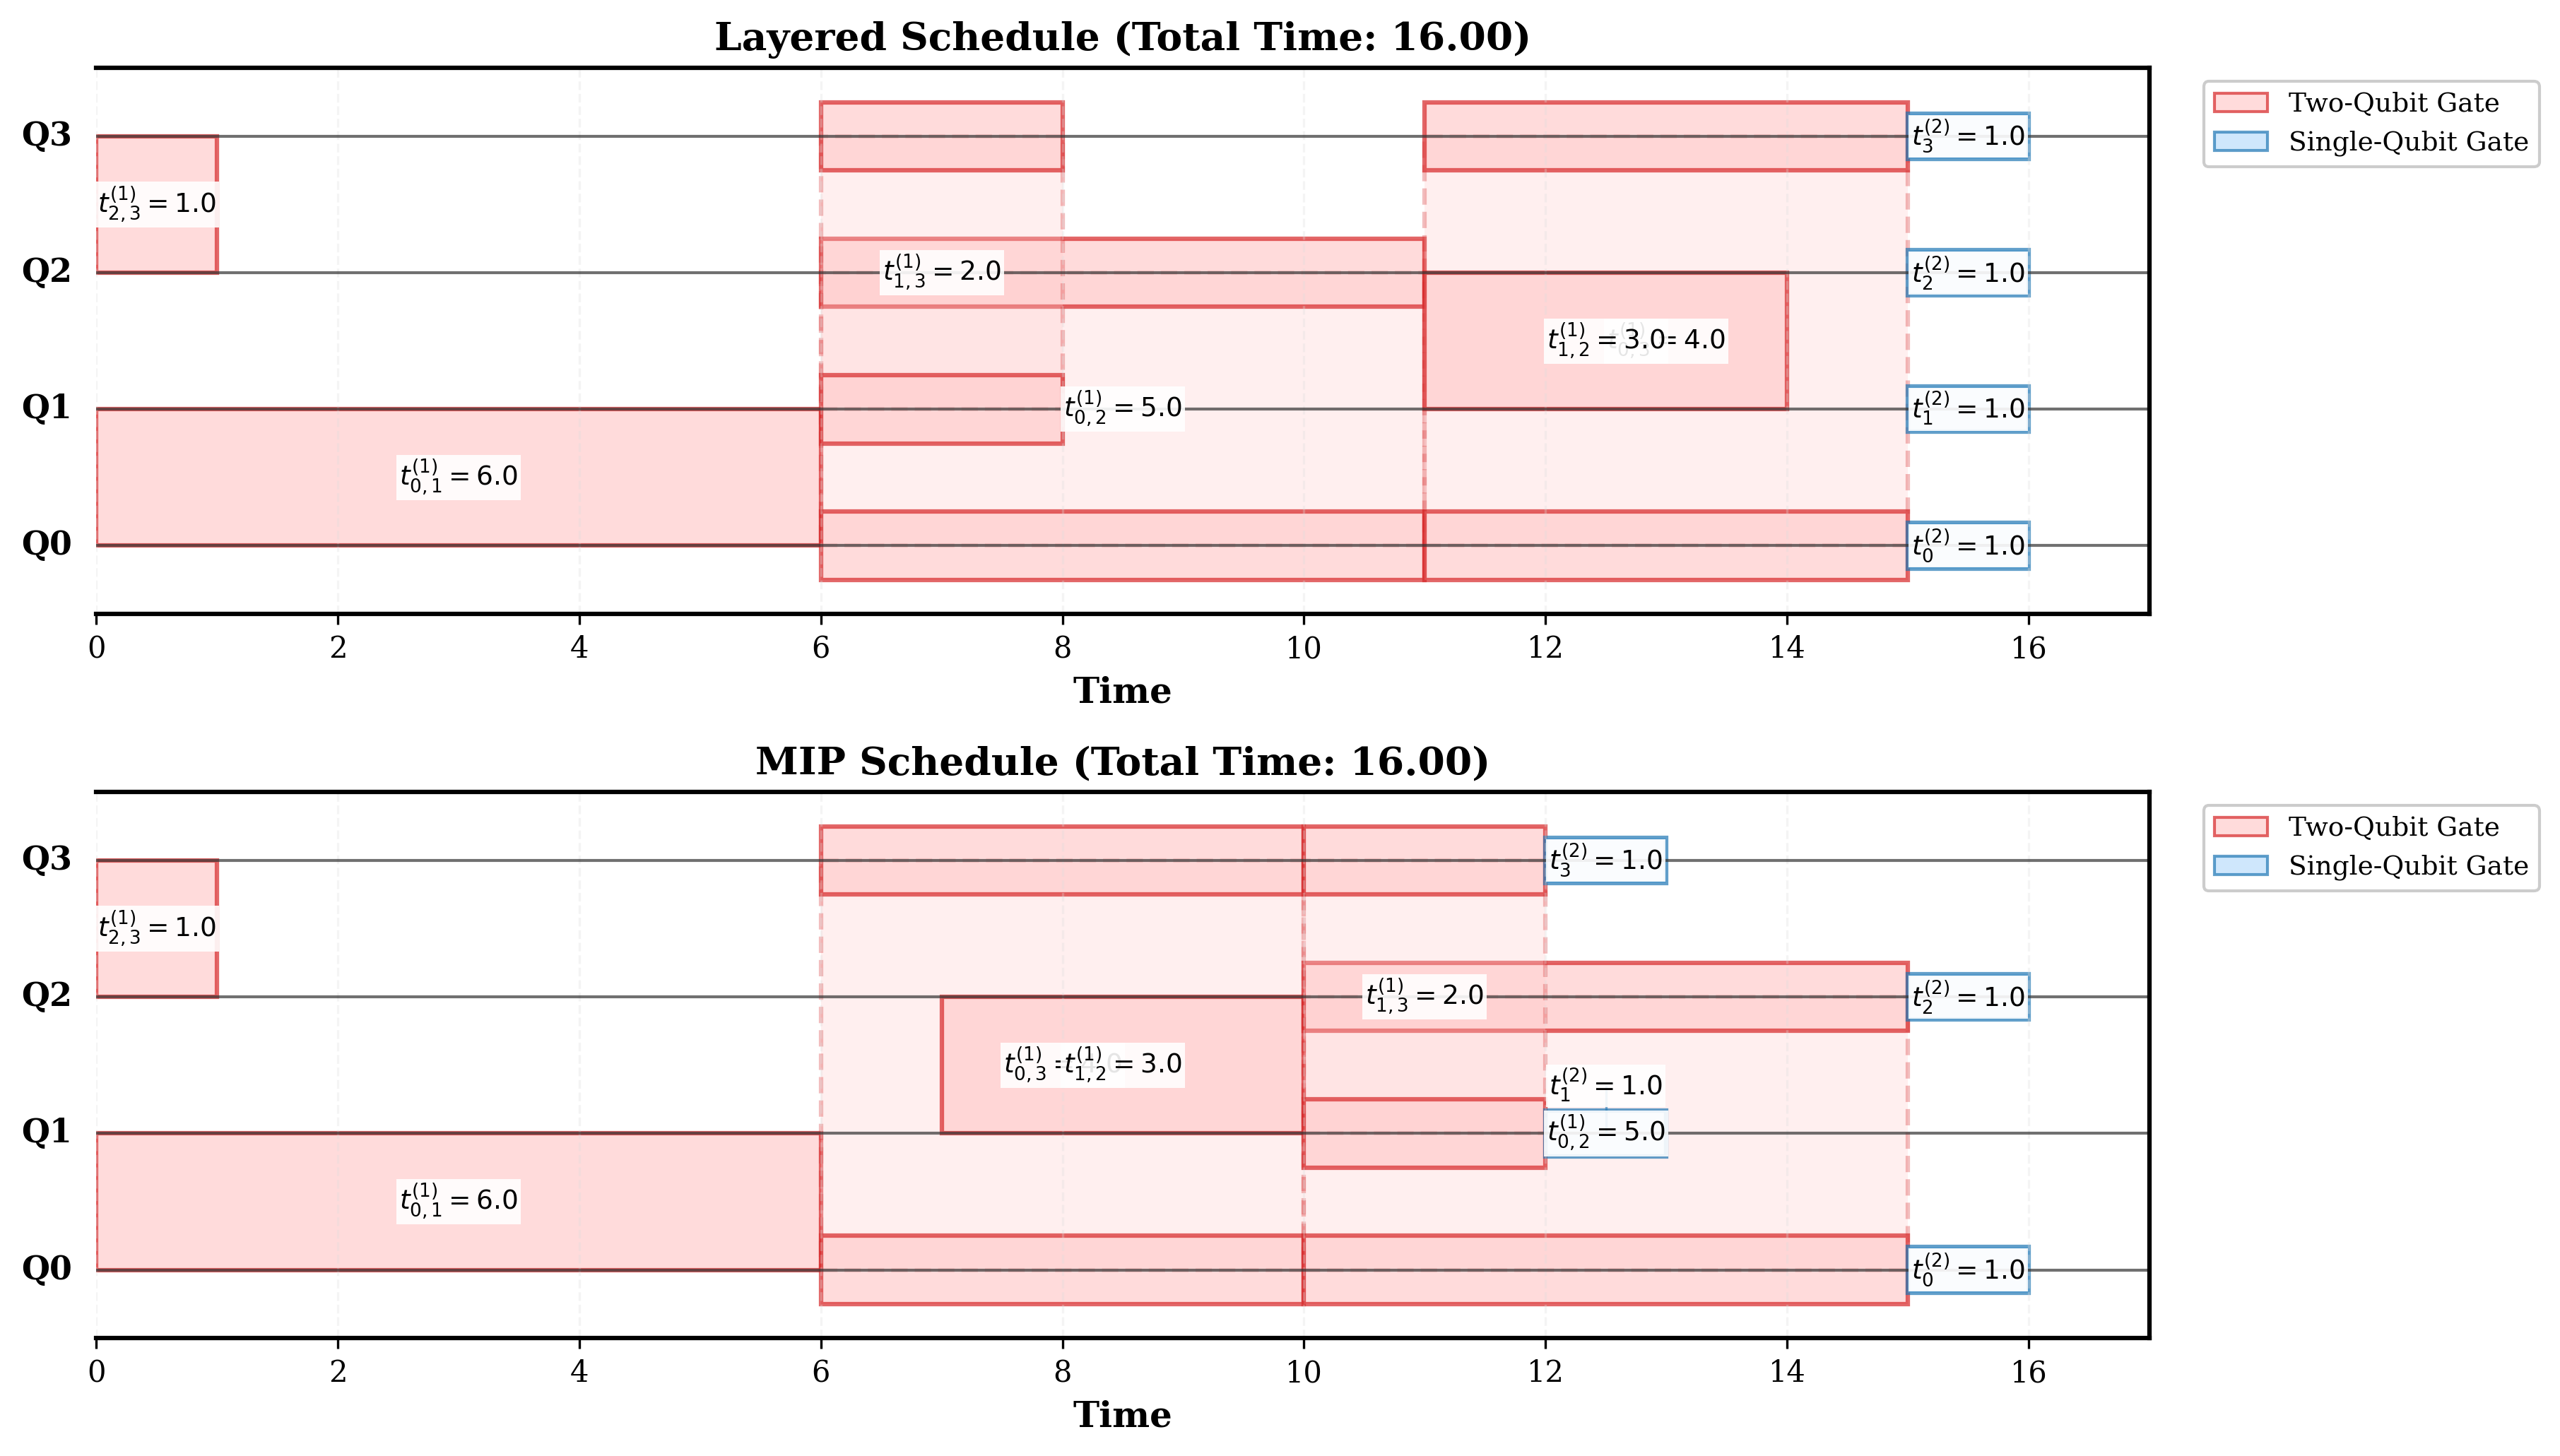

In [9]:
### K4 Example (Complete Graph)
def example_k4_circuit() -> QAOACircuit:
    """Create example QAOA circuit on 4 qubits with complete graph connectivity."""
    n_qubits = 4
    gamma_gates = {
        # Connections from vertex 0
        (0, 1): 6.0,
        (0, 2): 5.0,
        (0, 3): 4.0,
        # Connections from vertex 1
        (1, 2): 3.0,
        (1, 3): 2.0,
        # Connection from vertex 2
        (2, 3): 1.0,
    }
    beta_time = 1.0

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)


# Run K4 example
k4_circuit = example_k4_circuit()
k4_layered, k4_greedy, k4_lp = run_example_comparison(k4_circuit, "K4")